In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

In [261]:
# Chemin du fichier Excel
file_path = r"C:\Users\omar.hitar\Desktop\projet ML\dataset.xlsx"
# Charger le fichier Excel
data = pd.read_excel(file_path)

# PRE-PROCESSING

In [262]:
df = data.copy()

### Création des sous-ensembles (suite au EDA)

In [263]:
# Calculer le taux de valeurs manquantes pour chaque colonne
missing_rate = df.isna().sum()/df.shape[0]

In [264]:
# Filtrer les colonnes liées au sang selon le taux de valeurs manquantes
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])

# Filtrer les colonnes virales selon le taux de valeurs manquantes
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [265]:
# Définir les colonnes clés à conserver
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [266]:
# Réduire le DataFrame aux colonnes sélectionnées
df = df[key_columns + blood_columns + viral_columns]

### TrainTest - Nettoyage - Encodage

In [307]:
# Diviser le DataFrame en ensembles d'entraînement (80%) et de test (20%)
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [308]:
trainset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    4068
positive     447
Name: count, dtype: int64

In [309]:
testset['SARS-Cov-2 exam result'].value_counts()

SARS-Cov-2 exam result
negative    1018
positive     111
Name: count, dtype: int64

### Encodage

In [310]:
# Fonction pour encoder les données
def encodage(df):
    code = {'negative': 0,
            'positive': 1,
            'not_detected': -1,  # Gestion des valeurs manquantes
            'detected': 1}
    
    for col in df.select_dtypes('object').columns:
        print(f"Avant mapping, valeurs de {col} :\n{df[col].unique()}")
        df[col] = df[col].map(code).fillna(0).astype(int)  # Remplir NaN avec 0 et cast explicite à int
        print(f"Après mapping, valeurs de {col} :\n{df[col].unique()}")
        
    return df

In [269]:
# Fonction pour l'ingénierie de caractéristiques
def feature_engineering(df):
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    return df

In [270]:
# Fonction pour la gestion des valeurs manquantes
def imputation(df):
    df = df.dropna(axis=0)  # Remplace les valeurs manquantes par les médianes
    return df


In [311]:
# Prétraitement
def preprocessing(df):
    df = encodage(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result'].astype(int)  # Casting à int ici aussi
    
    print(y.value_counts())
    
    return X, y

In [313]:
X_train, y_train = preprocessing(trainset)

SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64


In [280]:
X_test, y_test = preprocessing(testset)

SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


In [281]:
# Prétraitement des données d'entraînement et de test
#X_train, y_train = preprocessing(trainset)
#X_test, y_test = preprocessing(testset)

## Procédure d'évaluation

In [282]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print("Matrice de confusion:")
    print(confusion_matrix(y_test, ypred))
    print("Rapport de classification:")
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()


## Modellisation


In [314]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [315]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [316]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [286]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest


C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Matrice de confusion:
[[89  6]
 [10  6]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        95
           1       0.50      0.38      0.43        16

    accuracy                           0.86       111
   macro avg       0.70      0.66      0.67       111
weighted avg       0.84      0.86      0.85       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hi

AdaBoost
Matrice de confusion:
[[87  8]
 [ 9  7]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        95
           1       0.47      0.44      0.45        16

    accuracy                           0.85       111
   macro avg       0.69      0.68      0.68       111
weighted avg       0.84      0.85      0.84       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("F

SVM
Matrice de confusion:
[[92  3]
 [11  5]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        95
           1       0.62      0.31      0.42        16

    accuracy                           0.87       111
   macro avg       0.76      0.64      0.67       111
weighted avg       0.85      0.87      0.86       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hi

KNN
Matrice de confusion:
[[90  5]
 [11  5]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        95
           1       0.50      0.31      0.38        16

    accuracy                           0.86       111
   macro avg       0.70      0.63      0.65       111
weighted avg       0.83      0.86      0.84       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\omar.hi

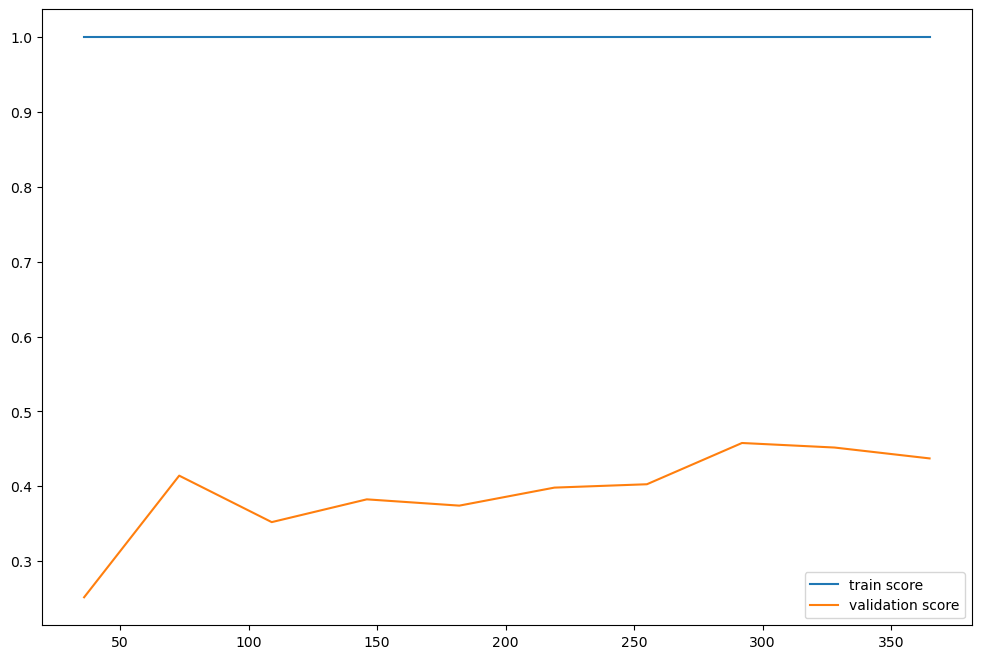

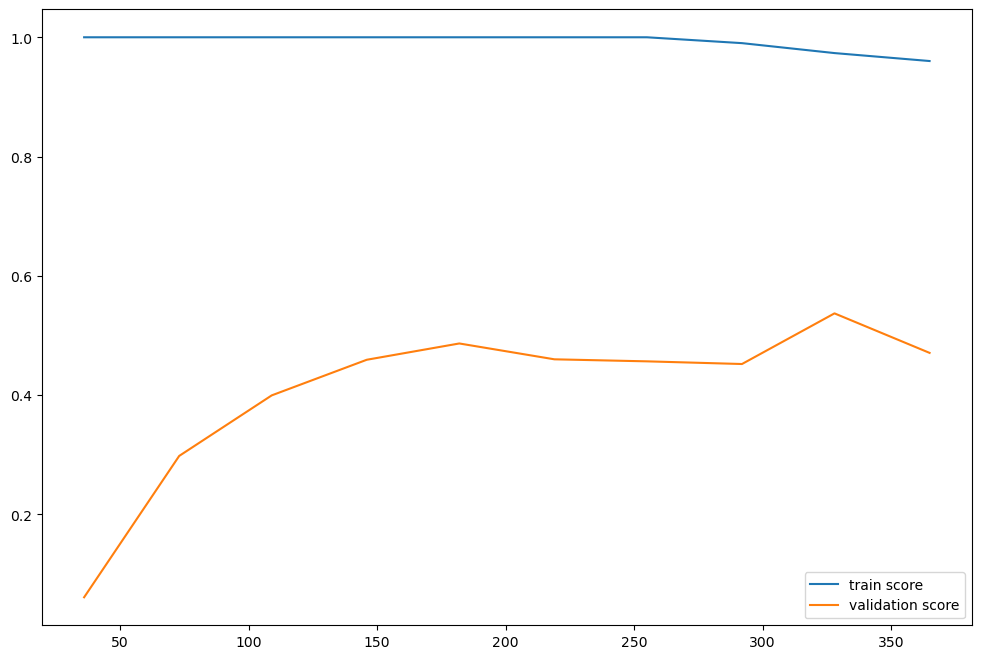

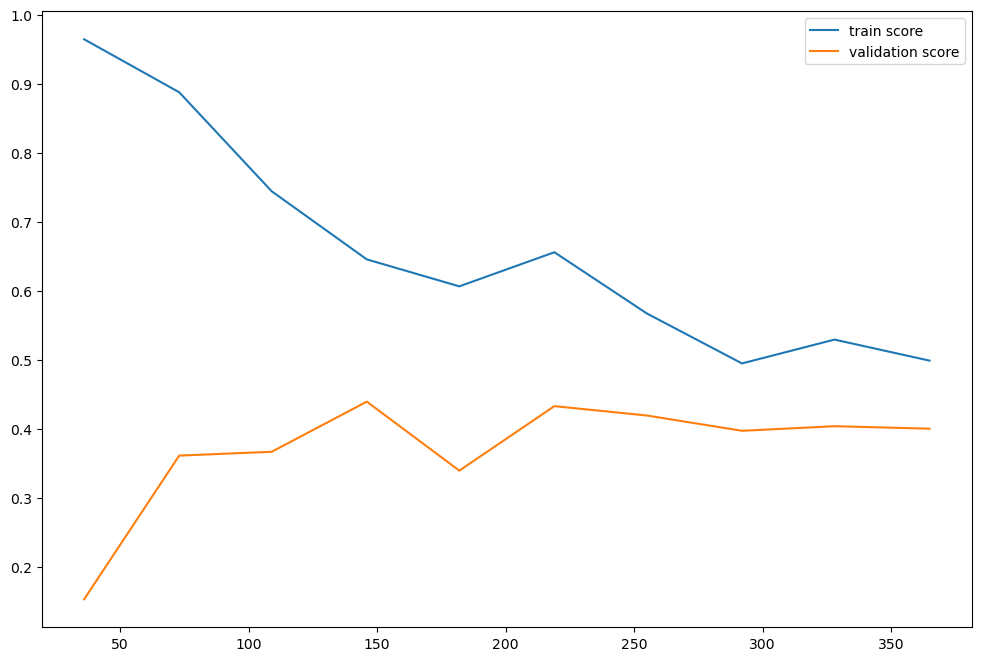

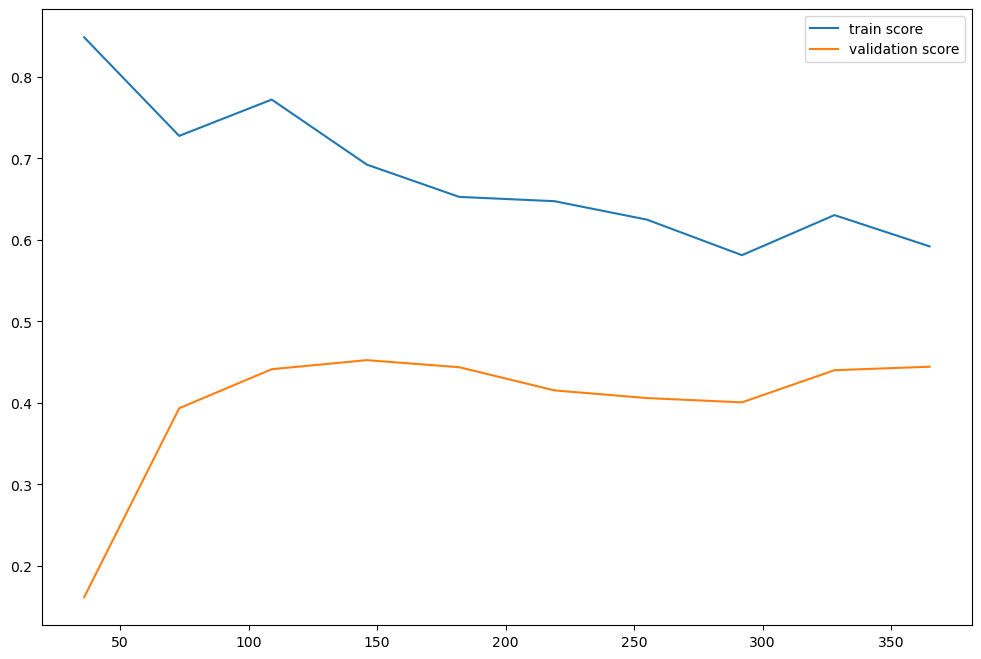

In [287]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## OPTIMISATION

In [288]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [289]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [293]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

In [294]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151 167
 182 196 209 221 232 242 251 259 266 272 277 281 284 286 287 302 316 329
 341 352 362 371 379 386 392 397 401 404 406 407 421 434 446 457 467 476
 484 491 497 502 506 509 511 512 525 537 548 558 567 575 582 588 593 597
 600 602 603 615 626 636 645 653 660 666 671 675 678 680 681 692 702 711
 719 726 732 737 741 744 746 747 757 766 774 781 787 792 796 799 801 802
 811 819 826 832 837 841 844 846 847 855 862 868 873 877 880 882 883 890
 896 901 905 908 910 911 917 922 926 929 931 932 937 941 944 946 947 951
 954 956 957 960 962 963 965 966 967] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid 

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 49, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        95
           1       0.54      0.44      0.48        16

    accuracy                           0.86       111
   macro avg       0.72      0.69      0.70       111
weighted avg       0.85      0.86      0.86       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151 167
 182 196 209 221 232 242 251 259 266 272 277 281 284 286 287 302 316 329
 341 352 362 371 379 386 392 397 401 404 406 407 421 434 446 457 467 476
 484 491 497 502 506 509 511 512 525 537 548 558 567 575 582 588 593 597
 600 602 603 615 626 636 645 653 660 666 671 675 678 680 681 692 702 711
 719 726 732 737 741 744 746 747 757 766 774 781 787 792 796 799 801 802
 811 819 826 832 837 841 844 846 847 855 862 868 873 877 880 882 883 890
 896 901 905 908 910 911 917 922 926 929 931 932 937 941 944 946 947 951
 954 956 957 960 962 963 965 966 967] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid 

C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151 167
 182 196 209 221 232 242 251 259 266 272 277 281 284 286 287 302 316 329
 341 352 362 371 379 386 392 397 401 404 406 407 421 434 446 457 467 476
 484 491 497 502 506 509 511 512 525 537 548 558 567 575 582 588 593 597
 600 602 603 615 626 636 645 653 660 666 671 675 678 680 681 692 702 711
 719 726 732 737 741 744 746 747 757 766 774 781 787 792 796 799 801 802
 811 819 826 832 837 841 844 846 847 855 862 868 873 877 880 882 883 890
 896 901 905 908 910 911 917 922 926 929 931 932 937 941 944 946 947 951
 954 956 957 960 962 963 965 966 967] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid 

Matrice de confusion:
[[89  6]
 [ 9  7]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        95
           1       0.54      0.44      0.48        16

    accuracy                           0.86       111
   macro avg       0.72      0.69      0.70       111
weighted avg       0.85      0.86      0.86       111



C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 15  31  46  60  73  85  96 106 115 123 130 136 141 145 148 150 151 167
 182 196 209 221 232 242 251 259 266 272 277 281 284 286 287 302 316 329
 341 352 362 371 379 386 392 397 401 404 406 407 421 434 446 457 467 476
 484 491 497 502 506 509 511 512 525 537 548 558 567 575 582 588 593 597
 600 602 603 615 626 636 645 653 660 666 671 675 678 680 681 692 702 711
 719 726 732 737 741 744 746 747 757 766 774 781 787 792 796 799 801 802
 811 819 826 832 837 841 844 846 847 855 862 868 873 877 880 882 883 890
 896 901 905 908 910 911 917 922 926 929 931 932 937 941 944 946 947 951
 954 956 957 960 962 963 965 966 967] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\omar.hitar\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid 

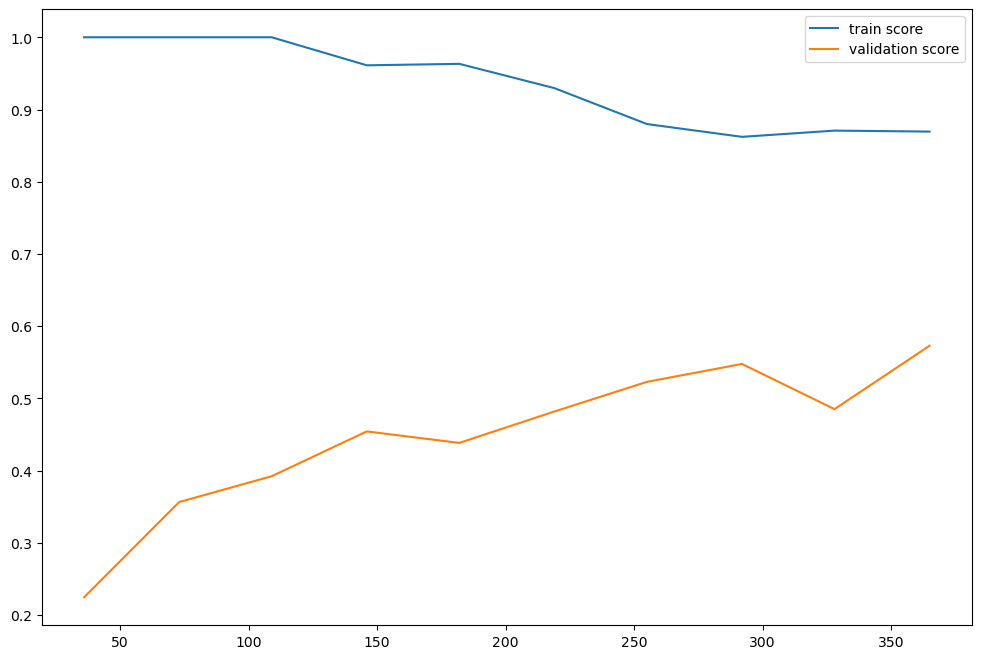

In [295]:
evaluation(grid.best_estimator_)

## Precision Recall Curve

In [317]:
from sklearn.metrics import precision_recall_curve

In [318]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

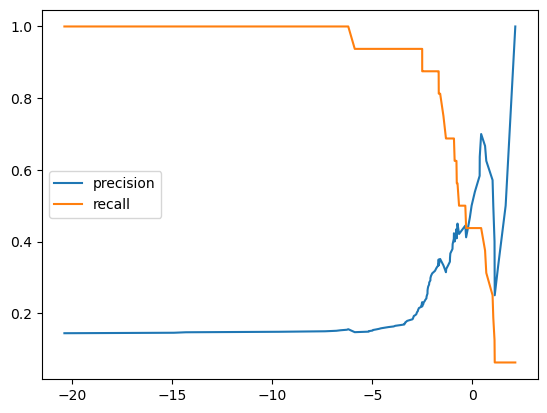

In [319]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [299]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [300]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [301]:
from sklearn.metrics import recall_score

In [302]:
f1_score(y_test, y_pred)

0.4888888888888889

In [303]:
recall_score(y_test, y_pred)

0.6875